<a href="https://colab.research.google.com/github/a-pujahari/EVA7/blob/main/Session5/EVA7_Session_5_Drill_Down_Part_1_Model_Structure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Target
1. Establish basic structure of model with the prior knowledge that

  a. Structures in MNIST images are visible at a level of 5x5, i.e Max pooling must be performed at receptive field of 5x5

  b. Go up to 32 channels to reduce total number of parameters (borrowed knowledge from class session 5)

  c. No Batch Normalization, Augmentation or Regularization to be used

# Results

Total parameters: 13,584

No dropout, Batch normalization or additional regularization used

Best training accuracy: 99.21% 15th Epoch

Best testing accuracy: 99.01% 14th Epoch

# Analysis

Both training and testing accuracy gradually increase together up to ~99%

Overfitting is minimal considering low difference between testing and training accuracies (except in the last 2 epochs).

Since the base model performs well without batch normalization or other significant additions, we can further reduce the number of parameters to improve model efficiency.

## Data Transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

## Download dataset & Specify transformations

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Dataloaders

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


## Model

In [5]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU()
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Summary

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,608
              ReLU-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 10, 24, 24]             320
         MaxPool2d-6           [-1, 10, 12, 12]               0
            Conv2d-7           [-1, 16, 10, 10]           1,440
              ReLU-8           [-1, 16, 10, 10]               0
            Conv2d-9             [-1, 16, 8, 8]           2,304
             ReLU-10             [-1, 16, 8, 8]               0
           Conv2d-11             [-1, 16, 6, 6]           2,304
             ReLU-12             [-1, 16, 6, 6]               0
           Conv2d-13             [-1, 16, 6, 6]           2,304
             ReLU-14             [-

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Define Train & Test Functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Train & Test

In [8]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.1487063616514206 Batch_id=937 Accuracy=38.06: 100%|██████████| 938/938 [00:48<00:00, 19.30it/s]



Test set: Average loss: 0.2812, Accuracy: 9158/10000 (91.58%)

EPOCH: 2


Loss=0.06281327456235886 Batch_id=937 Accuracy=94.86: 100%|██████████| 938/938 [00:48<00:00, 19.33it/s]



Test set: Average loss: 0.1017, Accuracy: 9677/10000 (96.77%)

EPOCH: 3


Loss=0.060121603310108185 Batch_id=937 Accuracy=97.04: 100%|██████████| 938/938 [00:48<00:00, 19.21it/s]



Test set: Average loss: 0.0690, Accuracy: 9790/10000 (97.90%)

EPOCH: 4


Loss=0.032647304236888885 Batch_id=937 Accuracy=97.72: 100%|██████████| 938/938 [00:52<00:00, 17.75it/s]



Test set: Average loss: 0.0670, Accuracy: 9789/10000 (97.89%)

EPOCH: 5


Loss=0.018860287964344025 Batch_id=937 Accuracy=98.18: 100%|██████████| 938/938 [00:54<00:00, 17.27it/s]



Test set: Average loss: 0.0513, Accuracy: 9833/10000 (98.33%)

EPOCH: 6


Loss=0.02379719167947769 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [00:54<00:00, 17.20it/s]



Test set: Average loss: 0.0442, Accuracy: 9849/10000 (98.49%)

EPOCH: 7


Loss=0.14853806793689728 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:54<00:00, 17.22it/s]



Test set: Average loss: 0.0433, Accuracy: 9872/10000 (98.72%)

EPOCH: 8


Loss=0.007734933868050575 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:55<00:00, 17.04it/s]



Test set: Average loss: 0.0334, Accuracy: 9892/10000 (98.92%)

EPOCH: 9


Loss=0.0053400034084916115 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:55<00:00, 16.82it/s]



Test set: Average loss: 0.0383, Accuracy: 9877/10000 (98.77%)

EPOCH: 10


Loss=0.00017424247926101089 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:56<00:00, 16.73it/s]



Test set: Average loss: 0.0299, Accuracy: 9892/10000 (98.92%)

EPOCH: 11


Loss=0.162278413772583 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:55<00:00, 16.95it/s]



Test set: Average loss: 0.0432, Accuracy: 9867/10000 (98.67%)

EPOCH: 12


Loss=0.040042098611593246 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:55<00:00, 16.88it/s]



Test set: Average loss: 0.0307, Accuracy: 9900/10000 (99.00%)

EPOCH: 13


Loss=0.0005680780159309506 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:55<00:00, 17.02it/s]



Test set: Average loss: 0.0372, Accuracy: 9883/10000 (98.83%)

EPOCH: 14


Loss=0.002514554187655449 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:55<00:00, 16.97it/s]



Test set: Average loss: 0.0317, Accuracy: 9901/10000 (99.01%)

EPOCH: 15


Loss=0.008616984821856022 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [00:55<00:00, 16.99it/s]



Test set: Average loss: 0.0366, Accuracy: 9876/10000 (98.76%)



Text(0.5, 1.0, 'Test Accuracy')

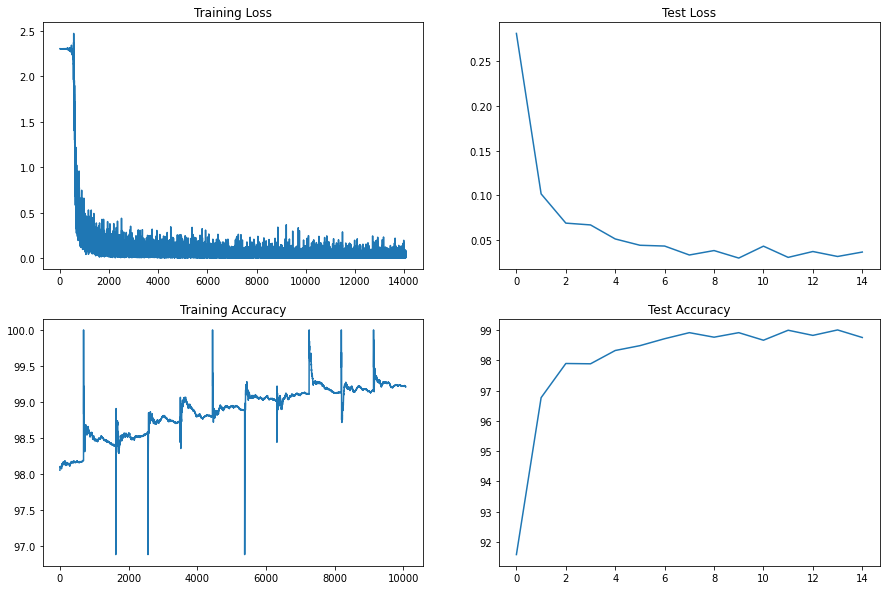

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")